### Basic Configuration

In [1]:
import warnings
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")

# Extra settings

plt.style.use('bmh')
mpl.rcParams["figure.figsize"] = (12,6)
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

In [2]:
dateparse = lambda x: datetime.strptime(x, '%d.%m.%Y')
df = pd.read_excel('Central Operations Specialist - Data for Home Task.xlsx', sheet_name = 'Data',
                   parse_dates =['Created Date'], date_parser = dateparse )

In [3]:
portugal = df[df['Country'] == 'Portugal'].reset_index(drop = True).copy()
ghana = df[df['Country'] == 'Ghana'].reset_index(drop = True).copy()

In [4]:
portugal

,Created Date,Country,City,Restaurant ID,Restaurant Name,Order State,Cancel Reason,Cuisine,Platform,Payment Method,Card Issuer,Products in Order,Order Value € (Gross),Delivery Fee,Delivery Time
0,2020-02-28,Portugal,Lisbon,7238,Chirashi - Alvalade,delivered,NaN,Sushi,ios,cashless,BANKINTER S.A.,13,89.30,0.0,17.7
1,2020-02-28,Portugal,Lisbon,12758,Istanbul Kebab Pizza - Alameda,delivered,NaN,Pizza,android,cashless,BANCO COMERCIAL PORTUGUES S.A.,1,10.00,0.0,16.3
2,2020-02-28,Portugal,Lisbon,6631,A-100 - Lisboa,delivered,NaN,Burgers,ios,cashless,BANCO COMERCIAL PORTUGUES S.A.,2,16.96,0.0,13.6
3,2020-02-28,Portugal,Lisbon,10535,La Paparrucha - Parrilla Argentina,delivered,NaN,South American,ios,cashless,ING BANK N.V.,3,25.15,4.2,26.1
4,2020-02-28,Portugal,Lisbon,9695,Choupana Caffe,delivered,NaN,Brunch,ios,cashless,INTESA SANPAOLO SPA,3,16.00,0.0,11.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85481,2020-01-01,Portugal,Lisbon,6070,Home Sweet Sushi - Miraflores,delivered,NaN,Sushi,ios,cashless,BANCO COMERCIAL PORTUGUES S.A.,3,18.50,0.0,23.6
85482,2020-01-01,Portugal,Lisbon,8439,Yokohama,delivered,NaN,Sushi,android,cashless,BANCO COMERCIAL PORTUGUES S.A.,1,13.76,0.0,11.8
85483,2020-01-01,Portugal,Lisbon,11466,Burger King - Av. Roma,delivered,NaN,Burgers,ios,cashless,BANCO BIC PORTUGUES S.A.,3,10.83,0.0,18.1
85484,2020-01-01,Portugal,Lisbon,11443,Don Costini Estefânia,delivered,NaN,Pizza,ios,cashless,BANCO SANTANDER TOTTA S.A.,1,8.05,0.0,11.8


### Creating a Data Pipeline to partially transform our data for easy visualization about seasonality

In [5]:
def country_ts(df):
    X= df.groupby('Created Date').size().to_frame()
    X_1 = df.groupby('Created Date').agg('sum')[['Order Value € (Gross)', 'Delivery Fee']]
    X = pd.concat([X, X_1], axis = 1)
    X['Weekday'] = X.index.strftime('%A')
    X['Week'] = X.index.isocalendar().week
    X.columns = ['Orders', 'Orders_Value', 'Fees', 'Weekday', 'Week']
    return X

In [6]:
port_ts = country_ts(portugal)
ghana_ts = country_ts(ghana)

In [7]:
def graph_timeseries(X,  country):
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=2)

    twin1 = ax.twinx()
    twin2 = ax.twinx()

    twin2.spines['right'].set_position(("axes", 1.07))

    p1, = ax.plot(X.index, X.Orders, "b-", label="# of Orders")
    p2, = twin1.plot(X.index, X['Orders_Value'], "r-", label="GMV orders")
    p3, = twin2.plot(X.index, X['Fees'], "g-", label="Applied Fees")

    ax.set_xlabel("Date")
    ax.set_ylabel("# of Orders")
    twin1.set_ylabel("GMV orders")
    twin2.set_ylabel("Applied Fees")

    ax.yaxis.label.set_color(p1.get_color())
    twin1.yaxis.label.set_color(p2.get_color())
    twin2.yaxis.label.set_color(p3.get_color())

    tkw = dict(size=4, width=1.5)
    ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
    twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    ax.tick_params(axis='x', **tkw)

    ax.legend(handles=[p1, p2, p3])
    plt.title( country + ' data evolution', fontsize = 18 , fontweight = 'bold')

# Question 1. - Do we have any seasonality in the countries shown?

First, we are going to explore how our important metrics have evolved during the timeperiod of interest. 

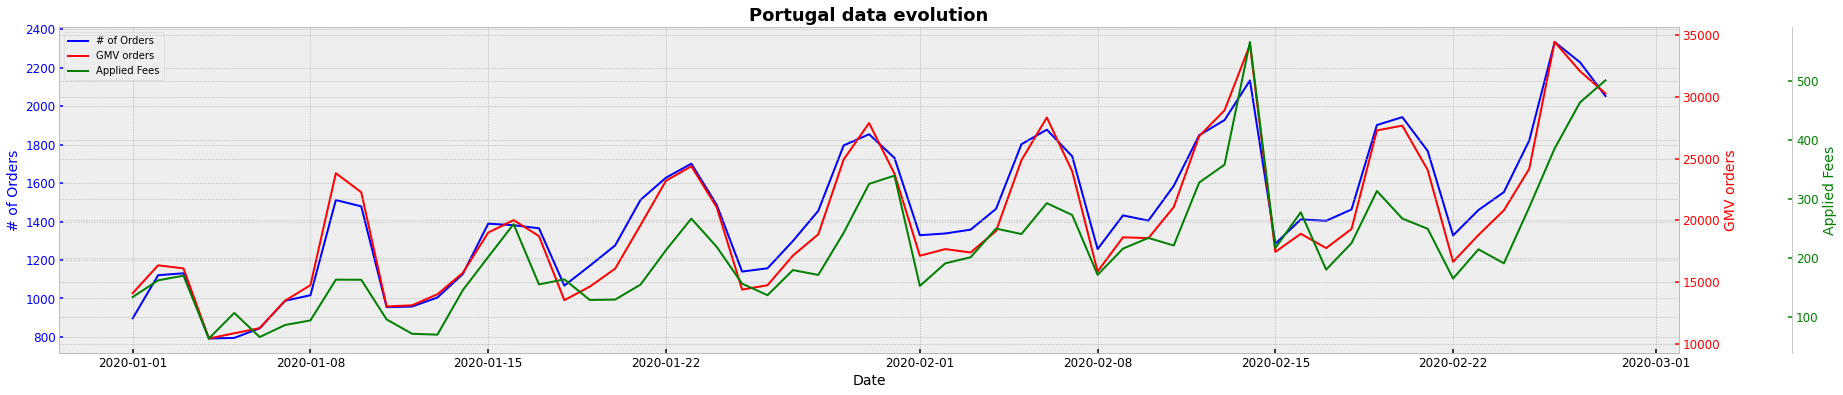

In [8]:
graph_timeseries(port_ts, 'Portugal')

Text(0.5, 0, '')

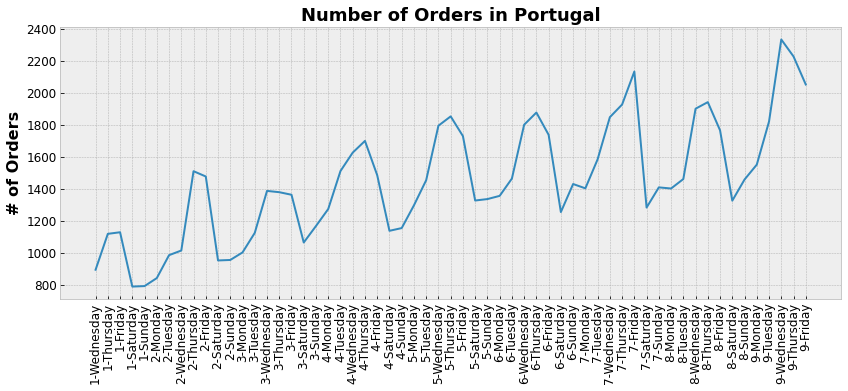

In [9]:
#plt.style.use('ggplot')
f, ax = plt.subplots(figsize=(14, 5))
fig = sns.lineplot(y= 'Orders' , x= port_ts.index , data= port_ts)

plt.title( 'Number of Orders in Portugal', fontsize = 18 , fontweight = 'bold')
plt.ylabel('# of Orders', fontsize = 16, fontweight = 'bold')
plt.xticks(ticks = port_ts.index , labels = port_ts['Week'].apply(str) + '-' + port_ts['Weekday'], rotation= 90,
          fontsize = 12 )
plt.xlabel('')

From these graphs we can conclude about Portugal that:

- It has a clear cyclic behavior, presumptively due to seasonality. Orders reaching their peak at Wed-Thu-Fri and valley at Sat-Sun.
- It has an upward trend in the number of Orders, its order seems to be 1 (linear)
- Differences in GMV vs #Orders behavior suggest that orders made during peaks have more total value that those made during valleys.
- Differences in Fees applied vs GMV and #Orders are more pronounced during peaks, suggesting that there's an opportunity to capitalize during these times make more profit, a dynamic pricing model could be implemented to improve the supply-demand equilibrium.

Text(0.5, 0, '')

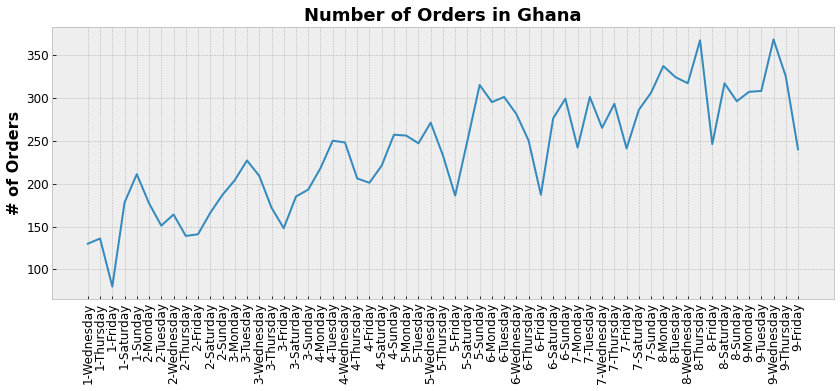

In [10]:
f, ax = plt.subplots(figsize=(14, 5))
fig = sns.lineplot(y= 'Orders' , x= ghana_ts.index , data= ghana_ts)

plt.title( 'Number of Orders in Ghana', fontsize = 18 , fontweight = 'bold')
plt.ylabel('# of Orders', fontsize = 16, fontweight = 'bold')
plt.xticks(ticks = ghana_ts.index , labels = ghana_ts['Week'].apply(str) + '-' + ghana_ts['Weekday'], rotation= 90,
          fontsize = 12)
plt.xlabel('')

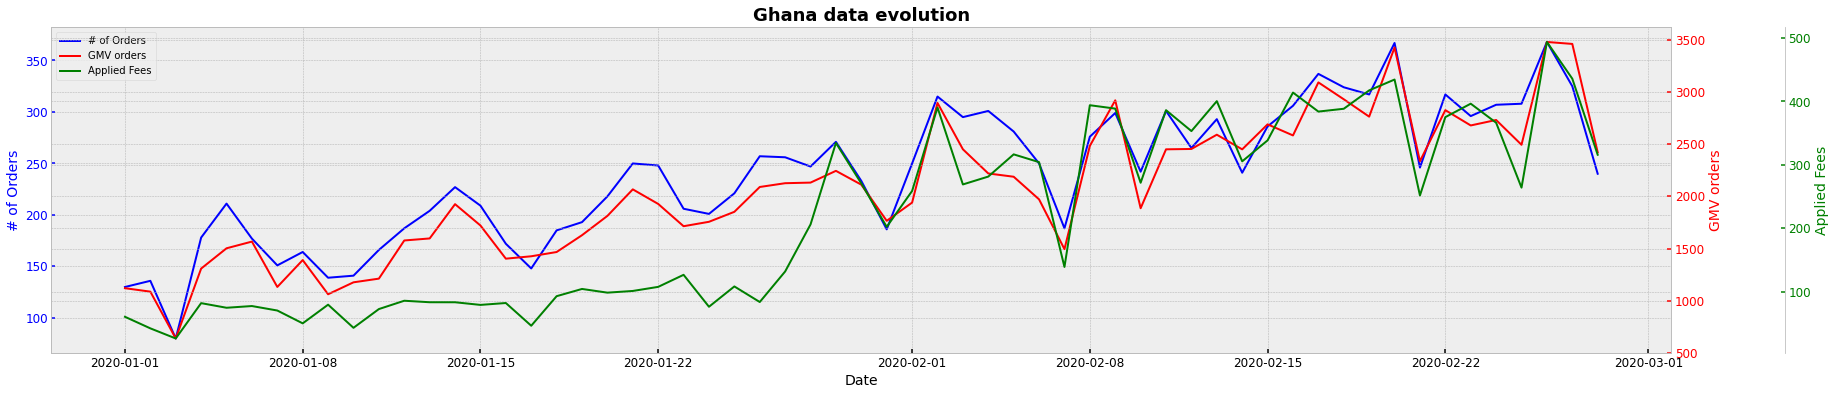

In [11]:
graph_timeseries(ghana_ts, 'Ghana')

From these graphs we can conclude about Ghana that:

- It has a not so clear cyclic behavior, presumptively due to seasonality. It isn't so easy to distinguish which days are peak days due to the short timeframe plus irregular evolution, but Wed-Tue-Mon-Sun are a good approximation, Thursday-Friday can be considered valley days and for sure its Friday the day that gives the series a seasonal behavior.
- It has an upward trend in the number of Orders, its order seems to be 1 (linear)
- There are no clear differences in GMV vs #Orders evolution contrary to Portugal.
- Differences in Fees applied vs GMV and #Orders notable until January 25th, due to product introduction or interest in growing in the market.

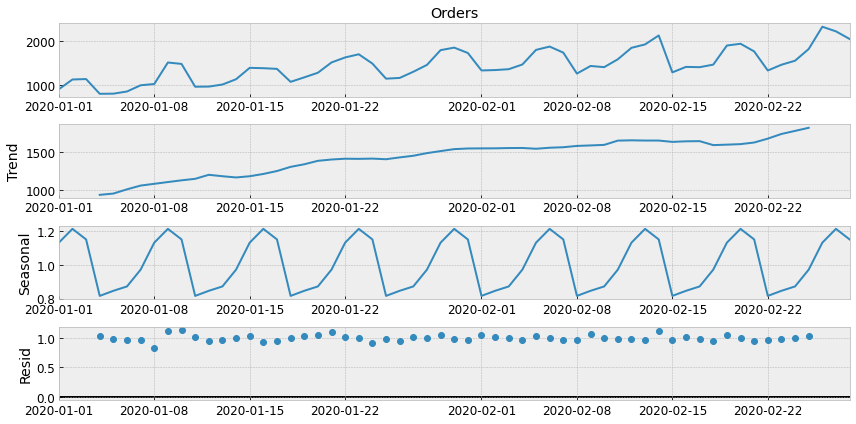

In [12]:
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(port_ts.Orders, model='multiplicative')
fig = result.plot()

After decomposing our Portuguese orders, we can observe that there's indeed a seasonal trend, from our graphs we can conclude that during peak hours our number of orders is multiplied by 21% and during valley hours Orders decrease by approx. 19%.

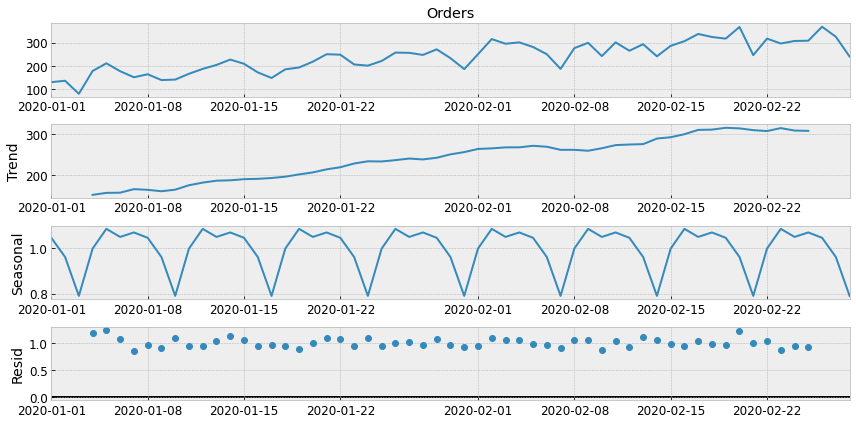

In [13]:
result = seasonal_decompose(ghana_ts.Orders, model='multiplicative')
fig = result.plot()

After decomposing our Ghanan orders we can observe that there's indeed a seasonal trend but its different than the Portuguese one, during the week order lvls are stable except for Thu-Fri-Sat being Friday our lowest weekly point, Orders dropping by aprox 21%.

#  2. Use your knowledge to predict with the available data, how many orders we will have in March 2020 in each country shown?


First, we are going to explore the performance of different prediction models in our data and try to choose the one that extropolates it the best.

We transform our data and build a pipeline to make the process easier if repetition is needed.

In [14]:
portugal_df = portugal.groupby('Created Date').size().to_frame()
portugal_df.columns = ['Orders']

In [15]:
def country_data_pipeline(df, split = True, split_date = None, target = None):
    
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df.drop(columns = 'date', inplace= True)
    
    if split == True:
        df_train = df.loc[df.index <= split_date]
        df_test = df.loc[df.index > split_date]
    
        y_train = df_train[target]
        X_train = df_train.drop([target], axis=1)
        y_test = df_test[target]
        X_test = df_test.drop([target], axis=1)
        
        return X_train, y_train, X_test, y_test
    
    else:
        return df

In [16]:
X_train, y_train, X_test, y_test = country_data_pipeline(portugal_df, split_date = '2020-02-15', target = 'Orders')

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_ss = scaler.transform(X_train)
X_test_ss = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_ss, columns=X_train.columns)
X_test = pd.DataFrame(X_test_ss, columns=X_test.columns)

After creating new attributes based on date details, we scale our data to improve our models' predictions.

And break our data into Train and test sets.

First, we try with a popular ML model, "Random Forest", we aren't going to optimize our model parameters yet because it will be a sink of time if our model isn't able to generalize to data outside the sample range (Extrapolate). Some ML models (Specific configurations of Neural networks) can extract useful abstractions about unseen data, but they require much more work for fine tunning. We have a small sample size (59 rows) so we will keep it simple.

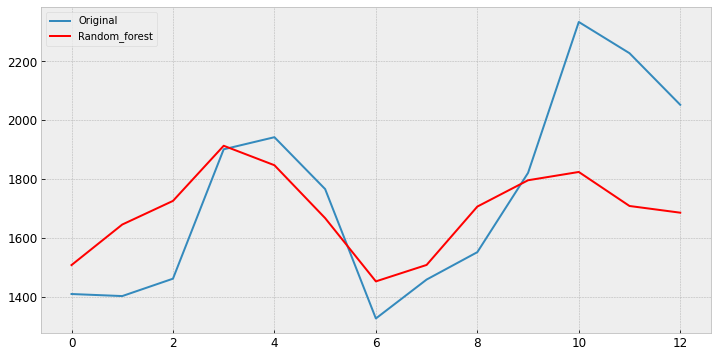

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

resultsDict = {}

reg = RandomForestRegressor(max_depth=5, random_state=0)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = mean_absolute_error(y_test, yhat)

plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='Random_forest')
plt.legend()

In [19]:
resultsDict

{'Randomforest': 196.83497549710214}

Not so bad Mean Absolute Error (MAE) for such a simple model, nevertheless it seems that it doesn't understand the trendiness in our timeseries.

Now we will try a XGBRegressor, it usually is better at generalizing and making abstractions.

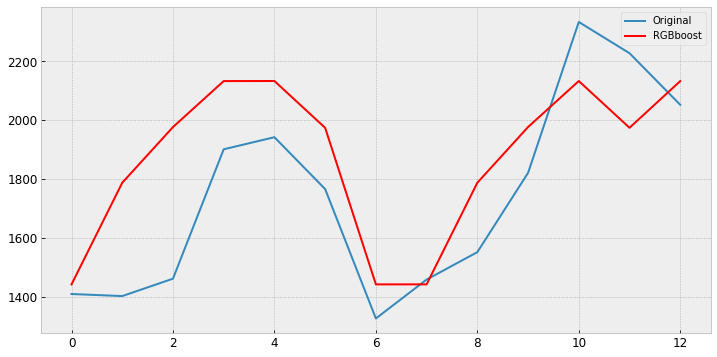

In [20]:
import xgboost as xgb
xgbo = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgbo.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = xgbo.predict(X_test)
resultsDict['XGBoost'] = mean_absolute_error(y_test, yhat)

plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='RGBboost')
plt.legend()

In [21]:
resultsDict

{'Randomforest': 196.83497549710214, 'XGBoost': 201.38880333533655}

We obtain a worse MAE, but it seems to represent better the cyclical nature of our series.

We now will try a more traditional method called SARIMA, its implementation already assumes that our data has a trend and a seasonal component, so probably it will generalize better.

The disadvantage of this method is that it requires more knowledge to be accurate because we need to set some parameters.

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)
Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

__Trend Elements:__

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

__Seasonal Elements:__

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.

__SARIMA notation:__
SARIMA(p,d,q)(P,D,Q,m)

We apply a SARIMA (1,0,1)(2,1,1,7) based on personal experience when looking at our timeseries decomposition.

c:\users\juan camilo\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\juan camilo\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\juan camilo\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='Created Date'>

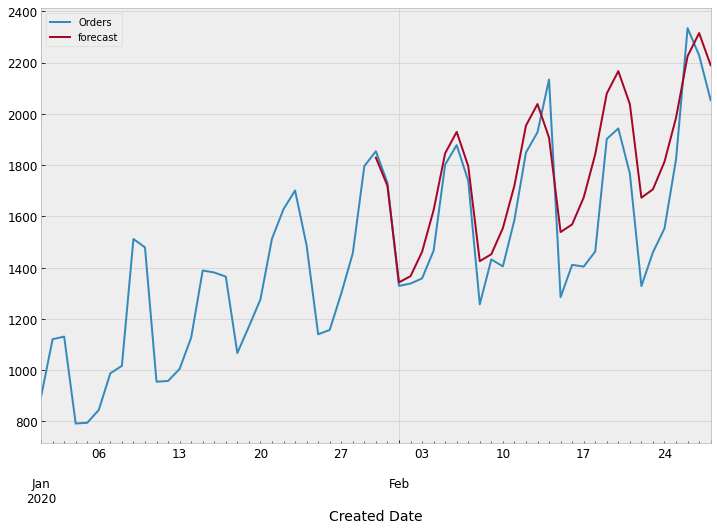

In [22]:
import statsmodels.api as sm

model= sm.tsa.statespace.SARIMAX(portugal_df['Orders'],order=(1, 0, 1), seasonal_order=(2,1,1,7), trend = 't')
results= model.fit()
portugal_df['forecast'] = results.predict(start=59-30,end=59, dynamic=1)
portugal_df[['Orders','forecast']].plot(figsize=(12,8))

In [23]:
resultsDict['SARIMA'] = mean_absolute_error(portugal_df[portugal_df.index >= '2020-02-15']['Orders'],
                                            portugal_df[portugal_df.index >= '2020-02-15']['forecast'])

In [24]:
resultsDict

{'Randomforest': 196.83497549710214,
 'XGBoost': 201.38880333533655,
 'SARIMA': 219.81009270970898}

In [25]:
from pandas.tseries.offsets import DateOffset
pred_date=[portugal_df.index[-1]+ DateOffset(days=x)for x in range(0,30)]

pred_date = pd.DataFrame(index=pred_date[1:],columns=portugal_df.columns)
data = pd.concat([portugal_df, pred_date])

<AxesSubplot:>

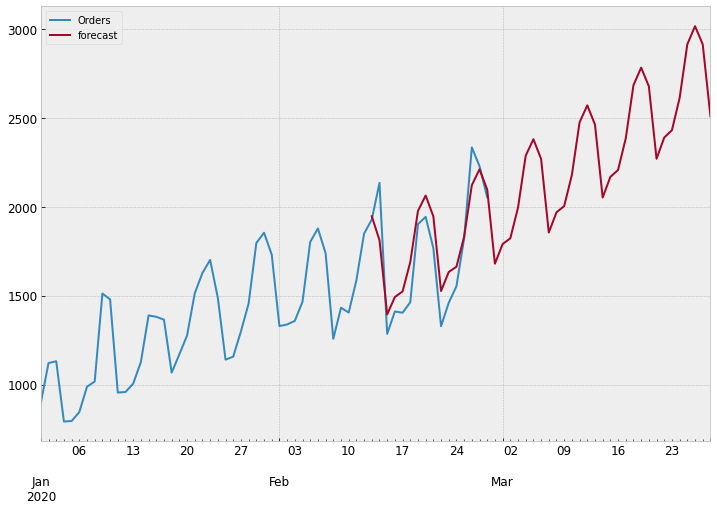

In [26]:
from pandas.tseries.offsets import DateOffset
pred_date=[portugal_df.index[-1]+ DateOffset(days=x)for x in range(0,30)]

pred_date = pd.DataFrame(index=pred_date[1:],columns=portugal_df.columns)
data = pd.concat([portugal_df, pred_date])
data['forecast'] = results.predict(start = 58-15, end = 59+30, dynamic= 1)  
data[['Orders', 'forecast']].plot(figsize=(12, 8))

As predicted, it is able to make good abstractions about our data, but it scores the worst MAE.

The best thing to do is to try to predict with our three models and choose one depending on how well it extrapolates.

We transform our data and make it ready to be processed by our models.

In [27]:
portugal_df = portugal.groupby('Created Date').size().to_frame()
portugal_df.columns = ['Orders']
pred_date=[portugal_df.index[-1]+ DateOffset(days=x)for x in range(0,30)]

pred_date = pd.DataFrame(index=pred_date[1:],columns=portugal_df.columns)
data = pd.concat([portugal_df, pred_date])

In [28]:
data = country_data_pipeline(data, split = False)

In [29]:
scaler = StandardScaler()
data.iloc[:,1:] = scaler.fit_transform(data.drop(columns = 'Orders'))
data

,Orders,dayofweek,dayofyear,sin_day,cos_day,dayofmonth,weekofyear
2020-01-01,897,-0.518820,-1.712479,1.189871,0.763494,-1.667988,-1.667350
2020-01-02,1121,-0.011529,-1.673112,1.285804,-0.588964,-1.550468,-1.667350
2020-01-03,1131,0.495762,-1.633744,0.199304,-1.400406,-1.432947,-1.667350
2020-01-04,792,1.003053,-1.594377,-1.070705,-0.924795,-1.315427,-1.667350
2020-01-05,795,1.510344,-1.555010,-1.356583,0.400594,-1.197906,-1.667350
...,...,...,...,...,...,...,...
2020-03-24,NaN,-1.026111,1.555010,1.036721,-0.962097,1.034980,1.629882
2020-03-25,NaN,-0.518820,1.594377,-0.249333,-1.392465,1.152501,1.629882
2020-03-26,NaN,-0.011529,1.633744,-1.306420,-0.543081,1.270021,1.629882
2020-03-27,NaN,0.495762,1.673112,-1.162661,0.805135,1.387542,1.629882


In [30]:
reg.fit(data.drop(columns = 'Orders')[data.index <= '2020-02-28'],
        data.Orders[data.index <= '2020-02-28'])
xgbo.fit(data.drop(columns = 'Orders')[data.index <= '2020-02-28'],
         data.Orders[data.index <= '2020-02-28'])



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
data['Random_Forest'] = np.nan
data['Gradient_booster'] = np.nan

data.iloc[-29:]['Random_Forest'] = reg.predict(data.drop(columns = ['Orders', 'Random_Forest', 'Gradient_booster'])
                                               [data.index > '2020-02-28'])
data.iloc[-29:]['Gradient_booster'] = xgbo.predict(data.drop(columns = ['Orders', 'Random_Forest', 'Gradient_booster'])
                                               [data.index > '2020-02-28']).astype('float')
data['SARIMA'] = results.predict(start = 58, end = 59+30, dynamic= 1)  

data

,Orders,dayofweek,dayofyear,sin_day,cos_day,dayofmonth,weekofyear,Random_Forest,Gradient_booster,SARIMA
2020-01-01,897,-0.518820,-1.712479,1.189871,0.763494,-1.667988,-1.667350,NaN,NaN,NaN
2020-01-02,1121,-0.011529,-1.673112,1.285804,-0.588964,-1.550468,-1.667350,NaN,NaN,NaN
2020-01-03,1131,0.495762,-1.633744,0.199304,-1.400406,-1.432947,-1.667350,NaN,NaN,NaN
2020-01-04,792,1.003053,-1.594377,-1.070705,-0.924795,-1.315427,-1.667350,NaN,NaN,NaN
2020-01-05,795,1.510344,-1.555010,-1.356583,0.400594,-1.197906,-1.667350,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-03-24,NaN,-1.026111,1.555010,1.036721,-0.962097,1.034980,1.629882,1866.343879,2205.330566,2543.693856
2020-03-25,NaN,-0.518820,1.594377,-0.249333,-1.392465,1.152501,1.629882,1987.635618,2333.891357,2995.916928
2020-03-26,NaN,-0.011529,1.633744,-1.306420,-0.543081,1.270021,1.629882,2012.635507,2228.025391,2989.388323
2020-03-27,NaN,0.495762,1.673112,-1.162661,0.805135,1.387542,1.629882,2074.403241,2053.003906,2883.383238


<AxesSubplot:>

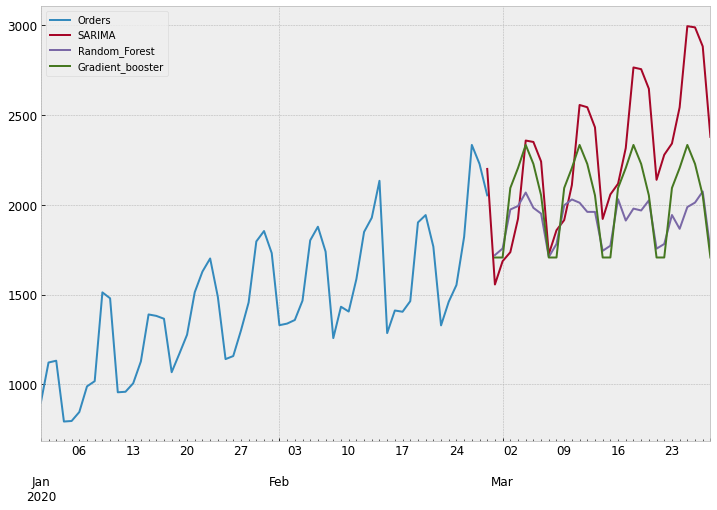

In [32]:
data[['Orders', 'SARIMA', 'Random_Forest', 'Gradient_booster']].plot(figsize=(12, 8))

As expected our SARIMA model is the one that extrapolates the best. Why our ML models performed worse? Its because they have never seen data from March. Our SARIMA models worked the best because we knew that our trend was linear (Order 1) and Seasonal(with increasing order in seasonality (2) with a weekly cycle).

A better model can be adjusted if more time is given, and if more data is available.

We continue with our Ghanese model.

We are going to apply SARIMA for our predictions assuming that this trend is also linear, and seasonality is weekly with an order of 2. -- This is an assumption, we expected similar behavior between similar products (delivery apps independently of local markets we could be wrong, but let's see the results)

In [33]:
ghana_df = ghana.groupby('Created Date').size().to_frame()
ghana_df.columns = ['Orders']

c:\users\juan camilo\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\juan camilo\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\juan camilo\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:>

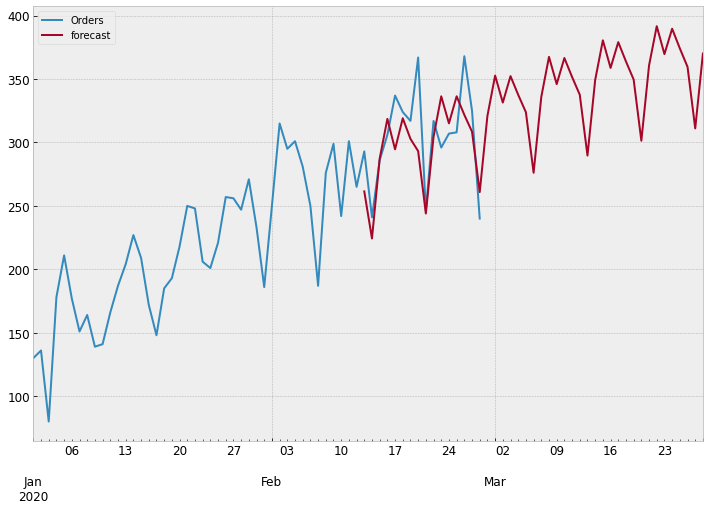

In [34]:
model= sm.tsa.statespace.SARIMAX(ghana_df['Orders'],order=(1, 0, 1), seasonal_order=(1,1,1,7), trend = 't')
results= model.fit()

pred_date=[ghana_df.index[-1]+ DateOffset(days=x)for x in range(0,30)]

pred_date = pd.DataFrame(index=pred_date[1:],columns=ghana_df.columns)
data_2 = pd.concat([ghana_df, pred_date])
data_2['forecast'] = results.predict(start = 58-15, end = 59+30, dynamic= 1)  
data_2[['Orders', 'forecast']].plot(figsize=(12, 8))

It seems to capture our market trends so we will stick with this model for convenience's sake.

Again, a better model can be adjusted if more time is given, and if more data is available.

Our forecasts are ready!!

In [35]:
Forecasts_march = pd.concat([data.iloc[-28:]['SARIMA'] , data_2.iloc[-28:]['forecast']], axis = 1)
Forecasts_march.columns = ['Portugal', 'Ghana']
Forecasts_march

,Portugal,Ghana
2020-03-01,1685.918372,352.732349
2020-03-02,1735.957326,331.469828
2020-03-03,1922.313143,352.305026
2020-03-04,2358.434587,337.574257
2020-03-05,2350.540133,323.847268
2020-03-06,2241.401457,276.133909
2020-03-07,1724.889959,335.985816
2020-03-08,1858.428389,367.496865
2020-03-09,1914.999041,346.018936
2020-03-10,2110.618738,366.590654


In [58]:
Forecasts_march.to_excel('Forecasts.xlsx')

Now lets see some insights about our data overlooked by our transformations.

## 3. Please tell us any other valuable insight that you can extract from the data available and what would you do to solve it.

We start by creating a pareto plot function to help us in the future.

In [36]:
def pareto_plot(df, x=None, y=None, title=None, show_pct_y=False, pct_format='{0:.0%}'):
    xlabel = x
    ylabel = y
    tmp = df.sort_values(y, ascending=False)
    x = tmp[x].values
    y = tmp[y].values
    weights = y / y.sum()
    cumsum = weights.cumsum()
    
    fig, ax1 = plt.subplots(figsize= (15,6))
    plt.xticks(rotation ='vertical')
    ax1.bar(x, y)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)

    ax2 = ax1.twinx()
    ax2.plot(x, cumsum, '-ro', alpha=0.5)
    ax2.set_ylabel('', color='r')
    ax2.tick_params('y', colors='r')
    
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    # hide y-labels on right side
    if not show_pct_y:
        ax2.set_yticks([])
    
    formatted_weights = [pct_format.format(x) for x in cumsum]
    for i, txt in enumerate(formatted_weights):
        ax2.annotate(txt, (x[i], cumsum[i] - 0.04), fontweight = 'heavy')    
    
    if title:
        plt.title(title)
    
    #plt.tight_layout()
    plt.show()

In [37]:
Cuisine_port = portugal.groupby('Cuisine').size().sort_values(ascending = False).to_frame().reset_index()
Cuisine_port.columns = ['Cuisine', 'Orders']

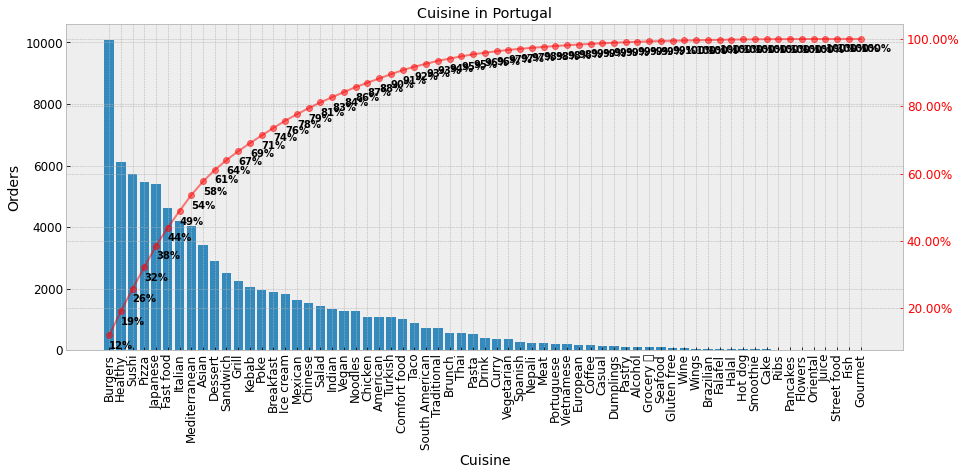

In [38]:
pareto_plot(Cuisine_port, x = 'Cuisine', y = 'Orders' , title= 'Cuisine in Portugal', show_pct_y=True)

From looking at Portuguese Cuisine we can conclude that:

- Only 7 types of Cuisine account for half of our Orders in Lisbon: Burgers, Healthy, Sushi, Pizza, Japanese, Fast Food and Italian. Focusing on adding new more restaurants that offer this kind of food into our app when expanding to new cities in this country will result in more Orders than any other combination. Also, we can charge more fees on niche Cuisine orders like Gourmet, Fish, Street food, juice, among others because they move our supply into low demand restaurants and are not very popular among app users.

In [39]:
rest_port = portugal.groupby('Restaurant Name').size().sort_values(ascending = False).to_frame().reset_index()
rest_port.columns = ['Restaurants', 'Orders']
rest_port.shape

(757, 2)

In [40]:
rest_port['Order_percent'] = rest_port['Orders'] * 100 / portugal.shape[0]
rest_port[rest_port['Order_percent'] >= 1]

,Restaurants,Orders,Order_percent
0,Burger King - Av. Roma,2860,3.345577
1,Subway - Saldanha,1675,1.959385
2,Poke House - Atrium Saldanha,1347,1.575697
3,Poke House - Chiado,1287,1.505510
4,4S Hamburger House,1117,1.306647
5,Choupana Caffe,1100,1.286760
6,Hello Beijing,1053,1.231781
7,Tasty Noodles,1047,1.224762
8,Poke House - Colombo,1029,1.203706
9,Josefino Pizza,1003,1.173292


From looking at Portugal Restaurants we can conclude that:

- We should have couriers close to the restaurants named in it, specially in BK Av Roma it makes for +3% of our orders in the city, and it could be a good idea to have dedicated couriers attending to these restaurants, in total they make for 20% of all orders in the City.

In [41]:
rest_port[rest_port['Order_percent'] >= 1].Order_percent.sum()

19.154013522682074

In [42]:
port_faulty = portugal[portugal['Order State'] != 'delivered']
port_faulty

,Created Date,Country,City,Restaurant ID,Restaurant Name,Order State,Cancel Reason,Cuisine,Platform,Payment Method,Card Issuer,Products in Order,Order Value € (Gross),Delivery Fee,Delivery Time
15,2020-02-28,Portugal,Lisbon,5684,Leads Pizza - Benfica,failed,Could not find a courier to deliver the order,Pizza,ios,cashless,BANCO COMERCIAL PORTUGUES S.A.,1,NaN,NaN,NaN
18,2020-02-28,Portugal,Lisbon,6801,Subway - Santos,rejected,The restaurant rejected the order,Sandwich,NaN,cashless,CAIXA GERAL DE DEPOSITOS SA,1,NaN,NaN,NaN
59,2020-02-28,Portugal,Lisbon,16030,The Green Affair - Saldanha,rejected,The restaurant rejected the order,Casual,android,cashless,BANCO COMERCIAL PORTUGUES S.A.,1,NaN,NaN,NaN
132,2020-02-28,Portugal,Lisbon,12721,Ali Baba Kebab Haus - Anjos,failed,Could not find a courier to deliver the order,Turkish,android,cashless,BANCO COMERCIAL PORTUGUES S.A.,2,NaN,NaN,NaN
369,2020-02-28,Portugal,Lisbon,14139,The Pop Star - Popcorn,failed,Could not find a courier to deliver the order,Dessert,ios,cashless,BANCO COMERCIAL PORTUGUES S.A.,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84882,2020-01-02,Portugal,Lisbon,4743,Sabores do Campo,failed,Could not find a courier to deliver the order,Grill,android,cashless,BANCO COMERCIAL PORTUGUES S.A.,1,NaN,NaN,NaN
85202,2020-01-01,Portugal,Lisbon,13142,Frei Petisco,rejected,The restaurant rejected the order,Breakfast,android,cashless,CAIXA CENTRAL DE CREDITO AGRICOLA MUTUO C.R.L.,4,NaN,NaN,NaN
85253,2020-01-01,Portugal,Lisbon,11466,Burger King - Av. Roma,rejected,The restaurant rejected the order,Burgers,android,cashless,CAIXA GERAL DE DEPOSITOS S.A.,2,NaN,NaN,NaN
85340,2020-01-01,Portugal,Lisbon,5905,Sakura - Picoas,failed,The restaurant asked customer support to fail ...,Sushi,android,cashless,CAIXA GERAL DE DEPOSITOS S.A.,3,NaN,NaN,NaN


<AxesSubplot:xlabel='Cancel Reason'>

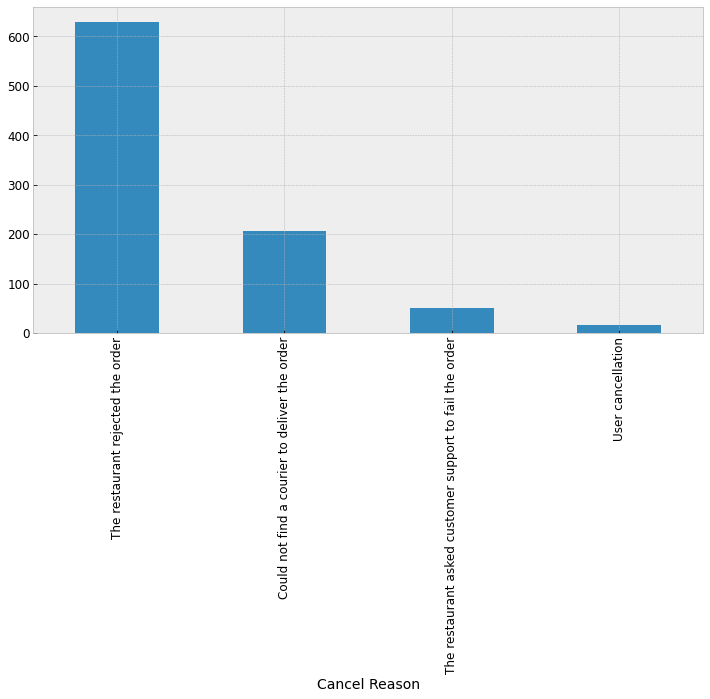

In [43]:
port_faulty.groupby('Cancel Reason').size().sort_values(ascending = False).plot.bar()

In [44]:
port_faulty_2 = port_faulty[port_faulty['Cancel Reason'] == 'The restaurant rejected the order']

<AxesSubplot:xlabel='Restaurant Name'>

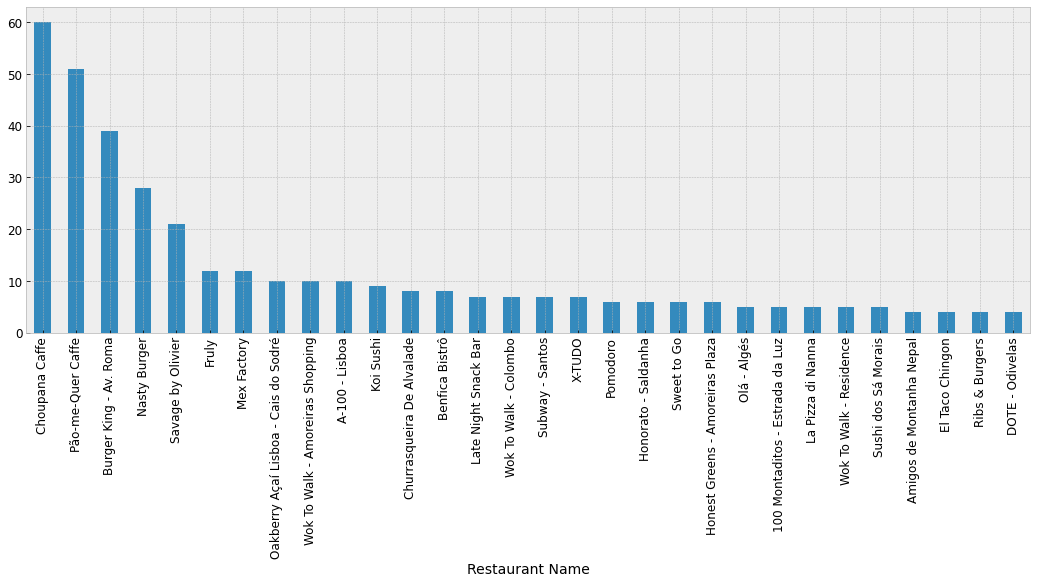

In [45]:
plt.figure(figsize = (18,6))
port_faulty_2.groupby('Restaurant Name').size().sort_values(ascending= False)[:30].plot.bar()

From our faulty orders plot, we can conclude that:

- The most common occurrence of faulty orders is that the restaurant rejects the order. After visualizing which restaurants reject the most orders, we can contact them to find out what are the reasons behind their cancelations, if a restaurant isn't able to met demand consistently (KPI: orders rejected/total orders) we can show the users less often these restaurants.

In [46]:
port_faulty_1 = port_faulty[port_faulty['Cancel Reason'] == 'Could not find a courier to deliver the order']

<AxesSubplot:xlabel='Created Date'>

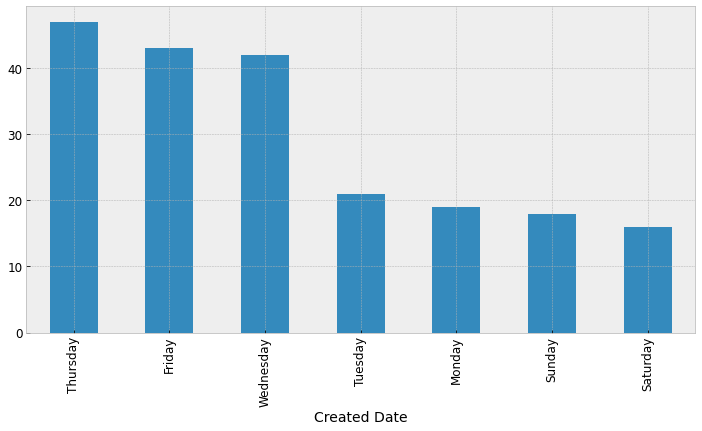

In [47]:
port_faulty_1.groupby(port_faulty_1['Created Date'].dt.day_name()).size().sort_values(ascending= False).plot.bar()

From our faulty orders plot, we can conclude that:

- The second most common occurrence of faulty orders is that we could not find a courier to deliver the order, after visualizing which days we failed the most orders, we found that those days are our Peak days, it isn't surprising. It could be a good idea to implement incentives during peak days to strengthen supply.

In [48]:
Cuisine_ghana = ghana.groupby('Cuisine').size().sort_values(ascending = False).to_frame().reset_index()
Cuisine_ghana.columns = ['Cuisine', 'Orders']
plt.style.use('ggplot')

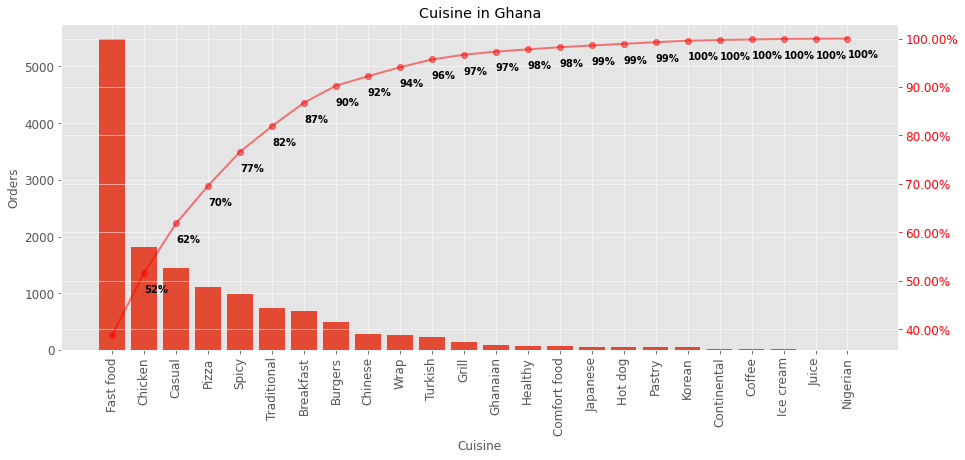

In [49]:
pareto_plot(Cuisine_ghana, x = 'Cuisine', y = 'Orders' , title= 'Cuisine in Ghana', show_pct_y=True)

From looking at Ghanese Cuisine we can conclude that:

- Only 4 types of Cuisine account for seventy percent of our Orders in Accra: Fast Food, Chicken, Casual and Pizza. Focusing on adding new more restaurants that offer this kind of food into our app when expanding to new cities in this country will result in more Orders than any other combination. Also, we can charge more fees on niche Cuisine orders like Ice cream, coffee, Nigerian, among others because they move our supply into low demand restaurants and are not very popular among app users.

In [55]:
rest_ghana = ghana.groupby('Restaurant Name').size().sort_values(ascending = False).to_frame().reset_index()
rest_ghana.columns = ['Restaurants', 'Orders']
rest_ghana['Order_percent'] = rest_ghana['Orders'] * 100 / ghana.shape[0]
rest_ghana[rest_ghana['Order_percent'] >= 2.5]

,Restaurants,Orders,Order_percent
0,KFC North Industrial,703,4.974526
1,KFC Marina Mall,590,4.174922
2,KFC East Legon,578,4.090008
3,KFC Circle,567,4.012171
4,FT - Tawakaltu Allah Lah,509,3.601755
5,Urban Taste Restaurant,448,3.170110
6,Aladdin Turkish Restaurant,423,2.993207
7,Grab & Go Foods,419,2.964902
8,Kiki's Pot,415,2.936598
9,Ando's Restaurant Dzorwulu,405,2.865836


In [57]:
rest_ghana[rest_ghana['Order_percent'] >= 2.5]['Order_percent'].sum()

44.020662326634586

From looking at Ghanese Restaurants we can conclude that:

- We should have couriers close to the restaurants named in it, specially in KFCs restaurants they make up to 20+% of our orders in the city, and it could be a good idea to have dedicated couriers attending to these restaurants, in total they make for 44% of all orders in the City.

<AxesSubplot:xlabel='Cancel Reason'>

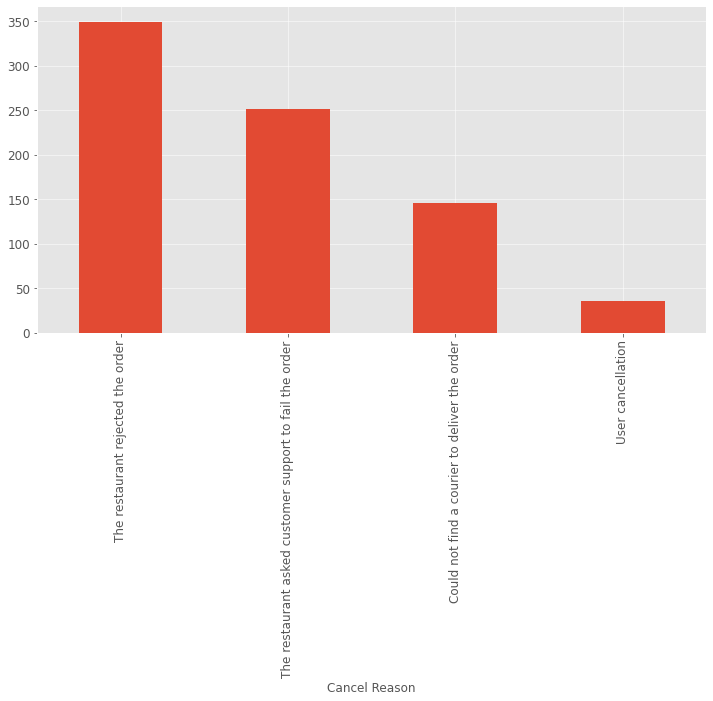

In [52]:
ghana_faulty = ghana[ghana['Order State'] != 'delivered']
ghana_faulty.groupby('Cancel Reason').size().sort_values(ascending = False).plot.bar()

From our faulty orders plot, we can conclude that:

- The second most common occurrence of faulty orders in Ghana is that the restaurant asked customer support to fail the order - No comments about that, don't know if it could be because of app's bugs, failure from the restaurant to prepare the food, or others causes.

<AxesSubplot:xlabel='Restaurant Name'>

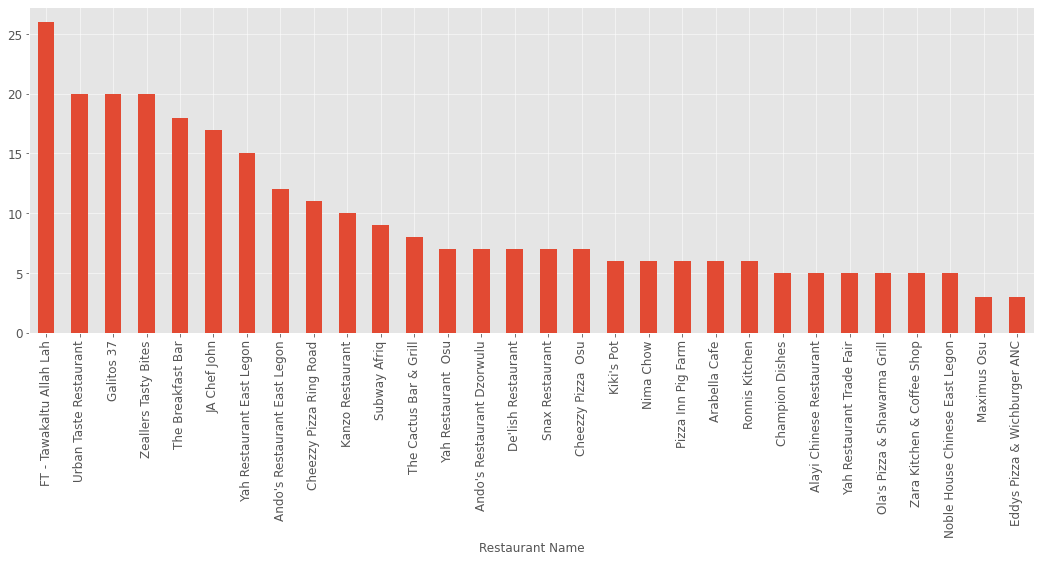

In [53]:
ghana_faulty_2 = ghana_faulty[ghana_faulty['Cancel Reason'] == 'The restaurant rejected the order']
plt.figure(figsize = (18,6))
ghana_faulty_2.groupby('Restaurant Name').size().sort_values(ascending= False)[:30].plot.bar()

From our faulty orders plot, we can conclude that:
- The most common occurence of faulty orders in Ghana is that the restaurant rejected the order, after visualizing which restaurants reject the most orders we can contact them to find out what are the reasons behind their cancelations, if a restaurant isnt able to met demand consistently (KPI: orders rejected/total orders) we can show the users less often these restaurants.